### Import Libraries

In [1]:
import h5py
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns

### Load Data

In [2]:
CUBE_PATH = "../sdss_cube_sfr/SDSS_cube_lean.h5"
cube = h5py.File(CUBE_PATH, "r")

spectra = cube["dense_cube/0/ml_spectrum/spectral_1d_cube_zoom_0"][:]
images = cube["dense_cube/0/ml_image/cutout_3d_cube_zoom_0"][:]
metadata = cube["dense_cube/0/ml_spectrum/spec_metadata_refs"][:]
sfrs = pd.read_hdf(CUBE_PATH, key="fits_spectra_metadata_star_formation_rates")

### Process Spectral Data

In [3]:
sfrs_notna = sfrs[sfrs["FLAG"] == 0.0]
metadata_indices = metadata[:, 0]["ds_slice_idx"]
common_indices = np.intersect1d(metadata_indices, sfrs_notna.index.values)
idx_spectra = np.isin(metadata_indices, common_indices)
X_spectra = spectra[idx_spectra]

def simplify_targettype(value):
    value = value.decode("utf-8").strip()
    if "GALAXY" in value:
        return "GALAXY"
    elif "QSO" in value or "QA" in value:
        return "QUASAR"
    elif "STAR" in value:
        return "STAR"
    else:
        return "OTHER"

sfrs["Simplified_TARGETTYPE"] = sfrs["TARGETTYPE"].apply(simplify_targettype)
Y = sfrs.loc[metadata_indices[idx_spectra], "Simplified_TARGETTYPE"].values

nan_rows = np.isnan(X_spectra).any(axis=1)
X_spectra = X_spectra[~nan_rows]
Y = Y[~nan_rows]

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

### Plot Class Distribution

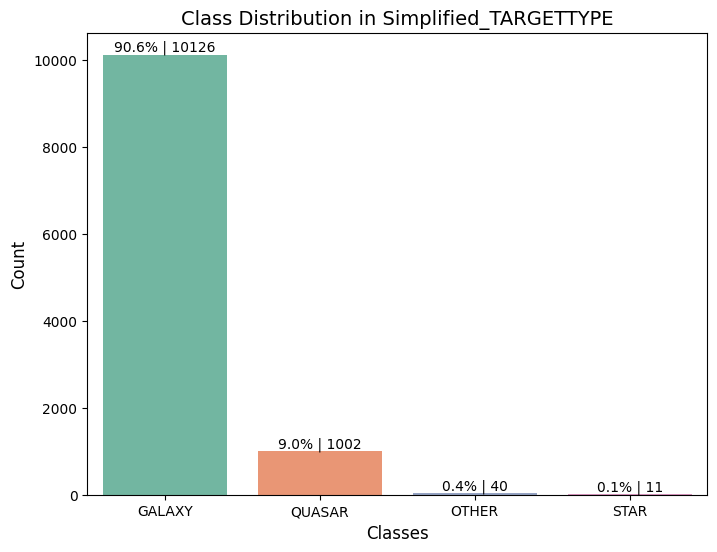

In [4]:
class_counts = pd.Series(Y).value_counts()
total_count = class_counts.sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,
    palette=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"],
    dodge=False,
    legend=False
)

for i, count in enumerate(class_counts):
    percent = (count / total_count) * 100
    ax.text(i, count, f"{percent:.1f}% | {count}", ha='center', va='bottom', fontsize=10, color="black")

ax.set_title("Class Distribution in Simplified_TARGETTYPE", fontsize=14)
ax.set_xlabel("Classes", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.legend([], [], frameon=False)
plt.show()

# Spectrum
### Visualize Average Spectra

In [5]:
print(f"Shape of X_spectra: {X_spectra.shape}")
print(f"Shape of Y: {Y.shape}")
print(f"Classes in Y: {np.unique(Y)}")

Shape of X_spectra: (11179, 4620)
Shape of Y: (11179,)
Classes in Y: ['GALAXY' 'OTHER' 'QUASAR' 'STAR']


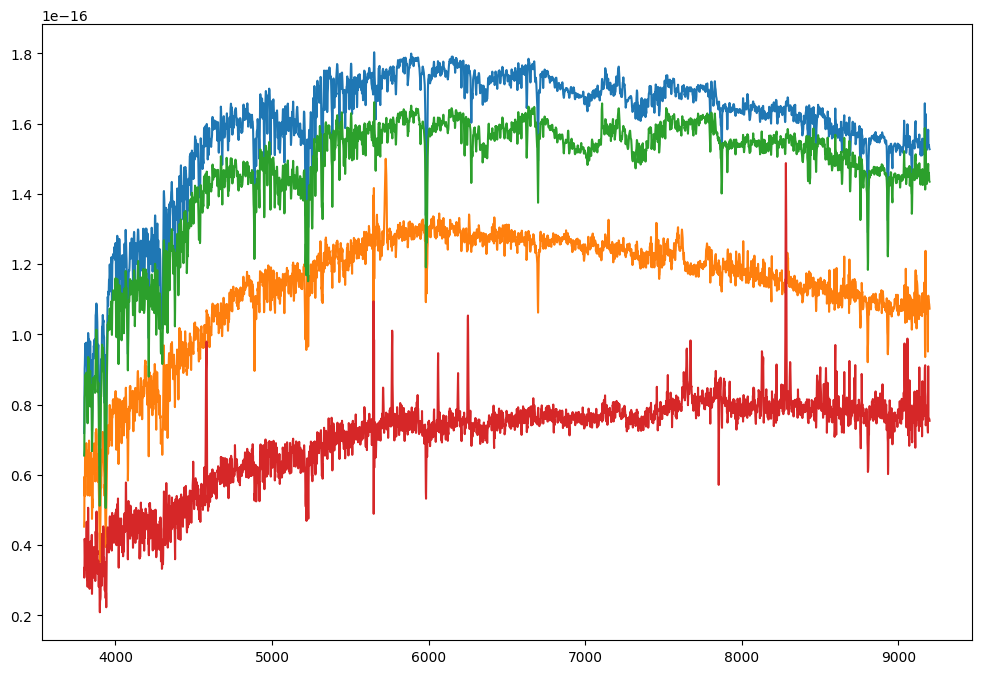

In [6]:
mean_spectra = {}
classes = np.unique(Y)

for cls in classes:
    mean_spectra[cls] = X_spectra[Y == cls].mean(axis=0)

plt.figure(figsize=(12, 8))
wavelengths = np.linspace(3800, 9200, X_spectra.shape[1]) 
for cls, spectrum in mean_spectra.items():
    plt.plot(wavelengths, spectrum, label=f"{cls} (mean spectrum)")

/tmp/ipykernel_3193423/4110036912.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


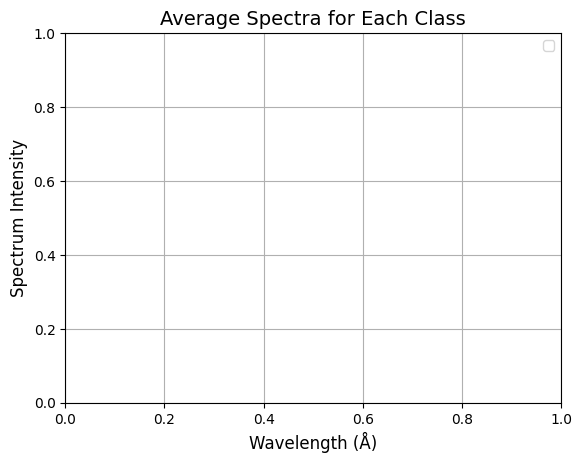

In [7]:
plt.title("Average Spectra for Each Class", fontsize=14)
plt.xlabel("Wavelength (Å)", fontsize=12)
plt.ylabel("Spectrum Intensity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

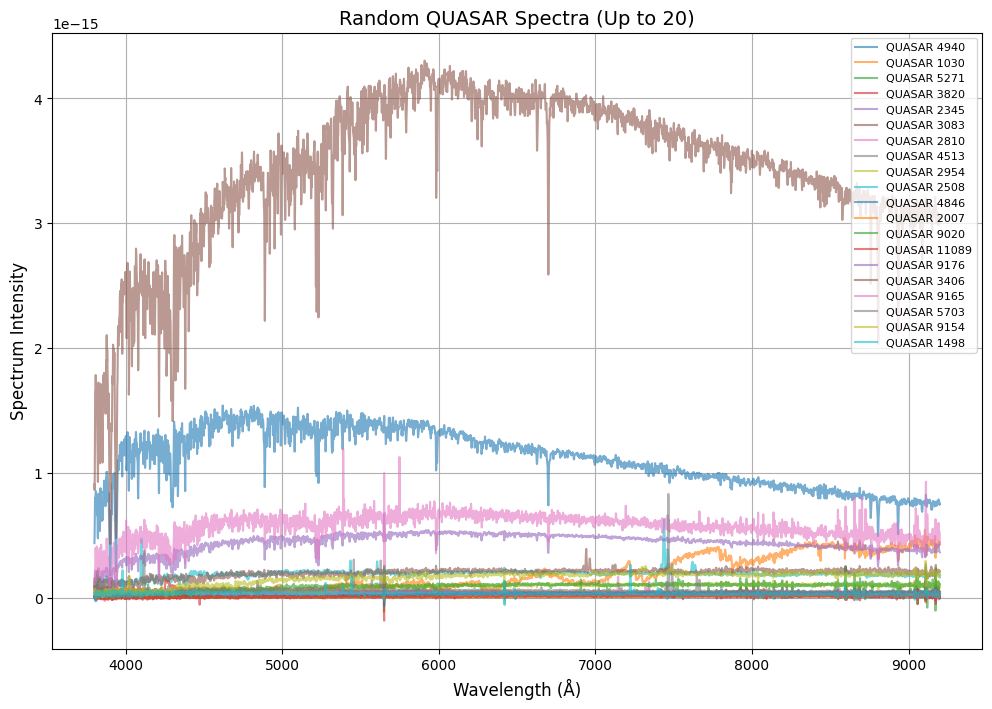

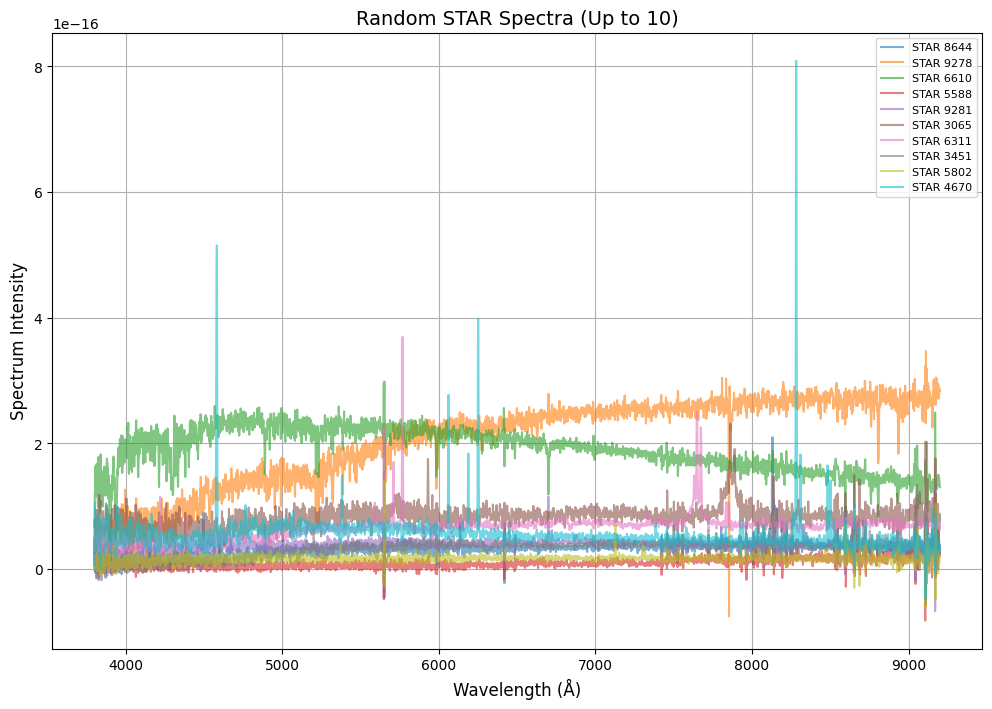

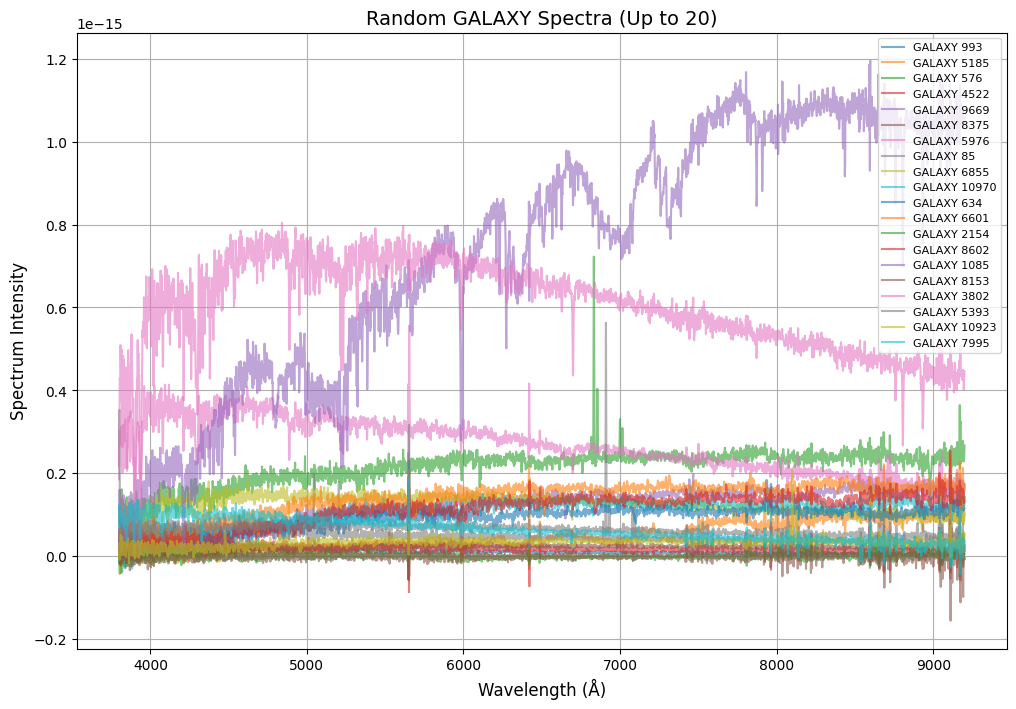

In [16]:
import random

def plot_random_spectra(X_spectra, Y, wavelengths, class_name, n=10):
    class_indices = np.where(Y == class_name)[0]
    if len(class_indices) > 0:
        random_indices = random.sample(list(class_indices), min(n, len(class_indices)))
        plt.figure(figsize=(12, 8))
        for i in random_indices:
            plt.plot(wavelengths, X_spectra[i], alpha=0.6, label=f"{class_name} {i}")
        plt.title(f"Random {class_name} Spectra (Up to {n})", fontsize=14)
        plt.xlabel("Wavelength (Å)", fontsize=12)
        plt.ylabel("Spectrum Intensity", fontsize=12)
        plt.grid(True)
        plt.legend(fontsize=8, loc="upper right")
        plt.show()
    else:
        print(f"No spectra found for class: {class_name}")

wavelengths = np.linspace(3800, 9200, X_spectra.shape[1]) 
plot_random_spectra(X_spectra, Y, wavelengths, "QUASAR", n=20)
plot_random_spectra(X_spectra, Y, wavelengths, "STAR", n=10)
plot_random_spectra(X_spectra, Y, wavelengths, "GALAXY", n=20)

### Train Decision Tree Model on Spectra

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_spectra, Y_encoded, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
print("Classification Report (Spectra):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report (Spectra):
              precision    recall  f1-score   support

      GALAXY       0.90      0.99      0.95      2016
       OTHER       0.00      0.00      0.00         6
      QUASAR       0.22      0.02      0.03       211
        STAR       0.00      0.00      0.00         3

    accuracy                           0.90      2236
   macro avg       0.28      0.25      0.25      2236
weighted avg       0.83      0.90      0.86      2236



/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# Images
### Process Image Data

In [10]:
n_samples_labels = Y_encoded.shape[0]
X_images = images[:n_samples_labels].reshape(n_samples_labels, -1)

nan_rows_images = np.isnan(X_images).any(axis=1)
X_images_filtered = X_images[~nan_rows_images]
Y_images_filtered = Y_encoded[~nan_rows_images]

### Train Decision Tree Model on Images

In [11]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_images_filtered, Y_images_filtered, test_size=0.2, random_state=42
)

dt_model_img = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model_img.fit(X_train_img, y_train_img)

y_pred_img = dt_model_img.predict(X_test_img)
print("Classification Report (Images):")
print(classification_report(y_test_img, y_pred_img, target_names=label_encoder.classes_))

Classification Report (Images):
              precision    recall  f1-score   support

      GALAXY       0.91      0.99      0.95      2022
       OTHER       0.00      0.00      0.00         7
      QUASAR       0.09      0.01      0.02       203
        STAR       0.00      0.00      0.00         2

    accuracy                           0.90      2234
   macro avg       0.25      0.25      0.24      2234
weighted avg       0.83      0.90      0.86      2234



/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# Combination
### Combine Spectra and Image Data

In [12]:
n_samples_combined = min(X_spectra.shape[0], X_images_filtered.shape[0])

X_spectra_combined = X_spectra[:n_samples_combined]
X_images_combined = X_images_filtered[:n_samples_combined]
Y_combined = Y_encoded[:n_samples_combined]

X_combined = np.hstack([X_spectra_combined, X_images_combined])
print(f"Shape of combined features: {X_combined.shape}")

Shape of combined features: (11169, 25100)


### Train Decision Tree Model on Combined Data

In [13]:
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, Y_combined, test_size=0.2, random_state=42
)

dt_model_comb = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_model_comb.fit(X_train_comb, y_train_comb)

y_pred_comb = dt_model_comb.predict(X_test_comb)
print("Classification Report (Combined):")
print(classification_report(y_test_comb, y_pred_comb, target_names=label_encoder.classes_))

Classification Report (Combined):
              precision    recall  f1-score   support

      GALAXY       0.90      0.99      0.95      2014
       OTHER       0.00      0.00      0.00         8
      QUASAR       0.22      0.02      0.04       210
        STAR       0.00      0.00      0.00         2

    accuracy                           0.90      2234
   macro avg       0.28      0.25      0.25      2234
weighted avg       0.83      0.90      0.86      2234



/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rustafar/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita